1.Make dir

In [2]:
import tensorflow as tf
import os

2023-06-22 14:39:33.817022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.experimental.list_physical_devices('GPU')

2023-06-19 11:27:40.163970: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[]

2023-06-19 11:27:41.161008: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 11:27:41.161521: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 11:27:41.161604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1990] Ignoring visible gpu device (device: 0, name: Radeon RX 560 Series, pci bus id: 0000:01:00.0) with AMDGPU version : gfx803. The supported AMDGPU versions are gfx1030, gfx900, gfx906, gfx908, gfx90a.


In [3]:
!mkdir -p {os.path.join('scratch','image_classification','logs')}

2.Remove Doggy Image

In [158]:
import cv2
import imghdr

In [159]:
data_dir = '/home/zok/joker/scratch/image_classification/data'
img_exts = ['jpeg','jpg','png','bmp']
data_dir

'/home/zok/joker/scratch/image_classification/data'

In [160]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

3.Load Data

In [3]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Tensor(3, s

In [161]:
import numpy
import matplotlib.pyplot as plt

In [162]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 183 files belonging to 2 classes.


2023-06-19 16:10:28.364246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [163]:
data_iterator = data.as_numpy_iterator()

In [164]:
batch = data_iterator.next()

2023-06-19 16:10:34.821603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [117]:
batch[0].shape

(32, 256, 256, 3)

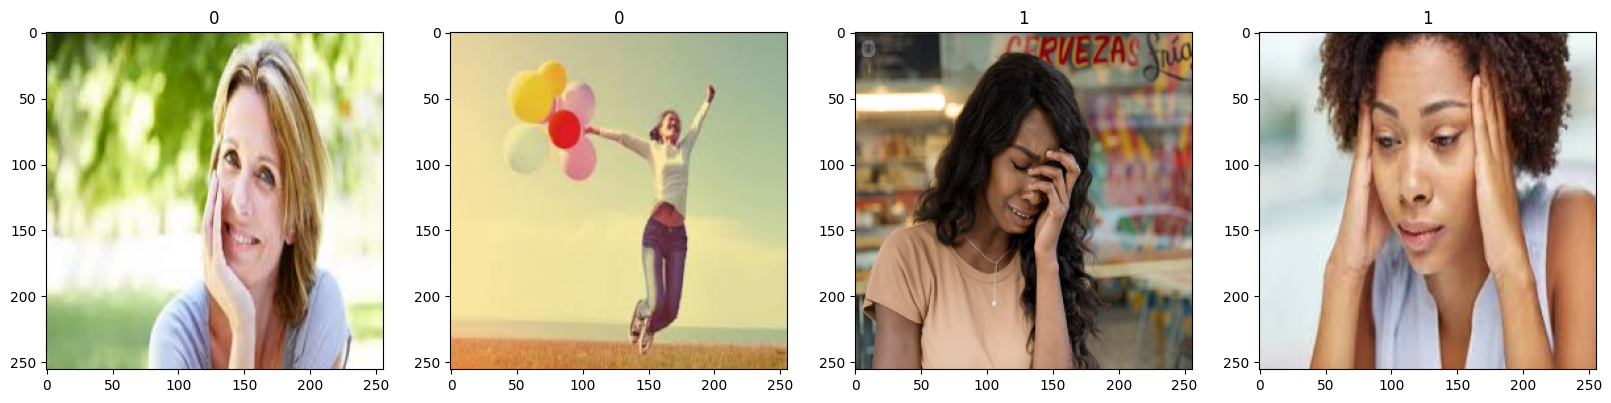

In [165]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4.Scale Data

In [166]:
data = data.map(lambda x,y: (x/255,y))

2023-06-19 16:10:49.279680: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [167]:
batch = data.as_numpy_iterator().next()

2023-06-19 16:10:56.541799: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:10:56.548931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


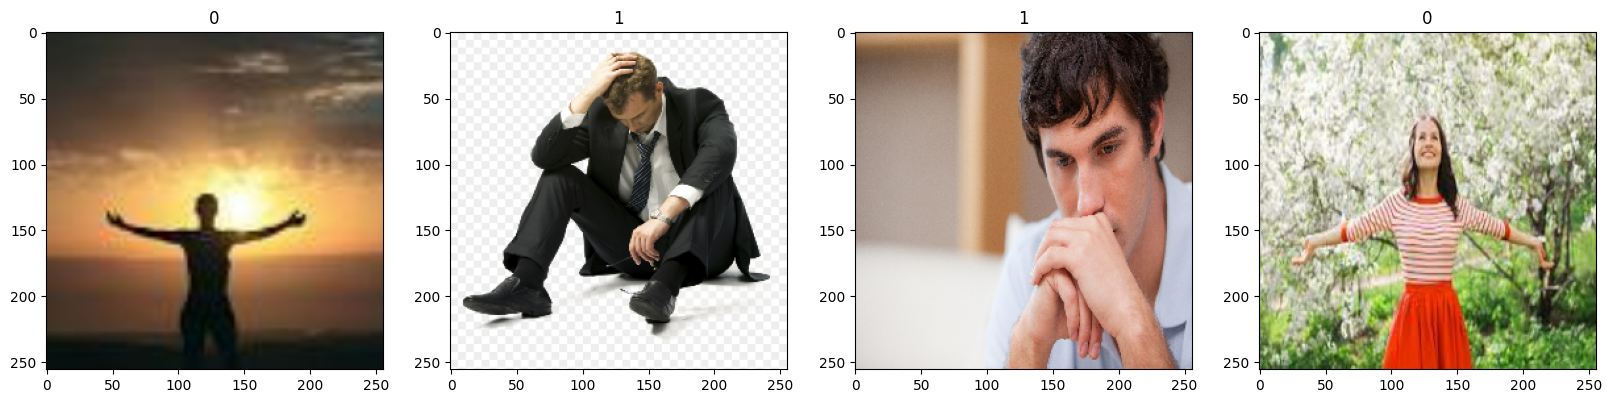

In [168]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

5.Spilt Data

In [169]:
len(data)*.7

4.199999999999999

In [170]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [171]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

6.Train

In [172]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [174]:
model = Sequential()

In [175]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [176]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [177]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

In [178]:
logsdir = os.path.join('scratch','image_classification','logs')

In [179]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsdir)

In [180]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-06-19 16:11:52.140213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:11:52.149512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:11:54.356917: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:11:54.387327: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


: 

: 

7.Plot Performance

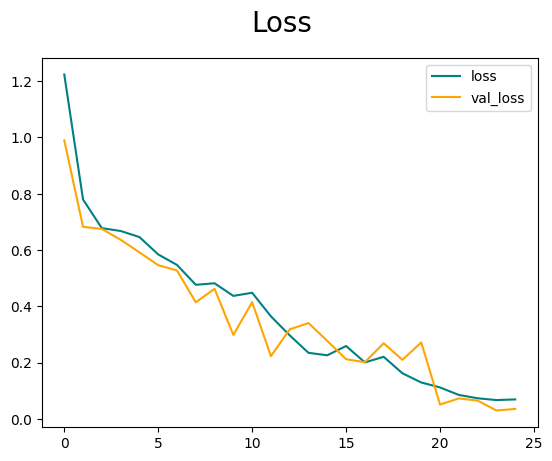

In [138]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize='20')
plt.legend(loc='upper right')
plt.show()

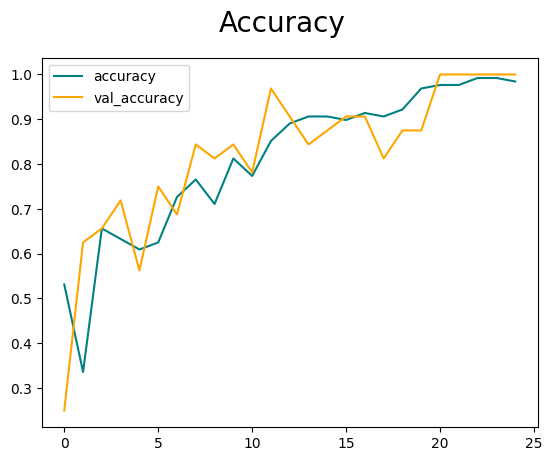

In [139]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize='20')
plt.legend(loc='upper left')
plt.show()

8.Evaluate Model

In [140]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [141]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [142]:
for batch in val.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-06-19 16:00:27.617158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:27.703358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:28.736256: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:28.756478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:28.767958: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:28.781456: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:28.797328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:28.804168: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:00:28.882089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


1/1 [==============================] - 0s 412ms/step


In [143]:
print(f'Precision:{pre.result()}, Recall:{re.result()}, Accuracy:{acc.result()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


9.Test

In [144]:
import cv2
import numpy as np

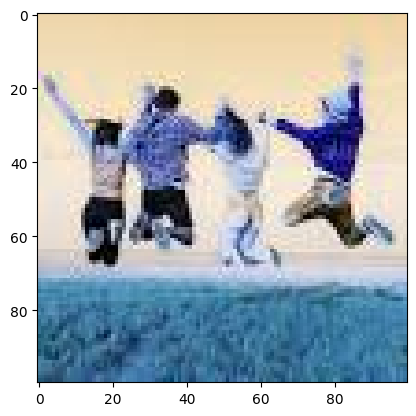

In [153]:
img = cv2.imread('/home/zok/joker/scratch/image_classification/data/happy/image (4).jpeg')
plt.imshow(img)
plt.show()

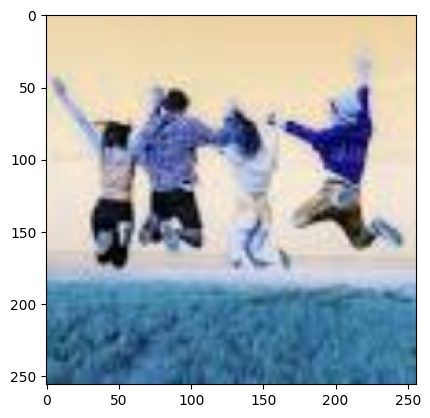

In [154]:

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [155]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 42ms/step


2023-06-19 16:05:06.947403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:05:06.963505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:05:06.972980: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:05:06.985945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:05:06.995472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-19 16:05:07.001102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [156]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('happysad.h5')

Segmentation

In [ ]:
import cv2
import numpy as np
import os
import uuid

import matplotlib.pyplot as plt

from skimage.feature import canny

import scipy.ndimage as nd

from skimage.filters import sobel
from skimage.segmentation import watershed

In [ ]:
!mkdir -p {os.path.join('scratch','image_classification','data','output')}

In [ ]:
file_list = os.listdir(r'/home/zok/joker/scratch/image_classification/data/input')

In [ ]:
IMAGES_PATH = os.listdir(r'/home/zok/joker/scratch/image_classification/data/output')

In [ ]:
IMAGES_PATH

[]

In [ ]:
def edge_to_image(edges):
	ls = []
	for i in range(edges.shape[0]):
		ls.append([0])
		for j in range(edges.shape[1]):
			filters = 255 if edges[i][j] else 0
			ls[i].append(filters)
	return np.matrix(ls, dtype=np.float32)

In [ ]:
def k_means_(img):
    Z = img.reshape((-1, 1))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    K = 3
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imgname = os.path.join('/home/zok/joker/scratch/image_classification/data/output',f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, res2)
    # cv2.imshow('Clustering: K-Means Segmentation', res2)
    # cv2.waitKey(0)   

In [ ]:
def image_segmentation(img_name,dir_path=r'/home/zok/joker/scratch/image_classification/data/input'):
    image_path = f'{dir_path}/{img_name}'
    image1 = cv2.imread(image_path)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

    ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY +
                                 cv2.THRESH_OTSU)
    # cv2.imshow('Threshold: Otsu+binary', thresh1)
    imgname = os.path.join('/home/zok/joker/scratch/image_classification/data/output',f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, thresh1)
    # cv2.waitKey(0)

    thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 199, 5)
    # cv2.imshow('Threshold: adaptive', thresh2)
    imgname = os.path.join('/home/zok/joker/scratch/image_classification/data/output',f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, thresh2)
    # cv2.waitKey(0)
    
    edges = canny(img)
    
    edge_image = edge_to_image(edges)
    
    # cv2.imshow('Edge: Edge detector',edge_image)
    # cv2.waitKey(0)
 
    fill_im = nd.binary_fill_holes(edges)
    fill_image = edge_to_image(fill_im)
    imgname = os.path.join('/home/zok/joker/scratch/image_classification/data/output',f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, fill_image)
    # cv2.imshow('Region: Region Filling', fill_image)
    # cv2.waitKey(0)

    elevation_map = sobel(img)
    
    fill_image = elevation_map*10
    # imgname = os.path.join('/home/zok/joker/scratch/image_classification/data/output',f'{str(uuid.uuid1())}.jpg')
    # cv2.imwrite(imgname, fill_image)
    # cv2.imshow('Watershed: Elevation Map', fill_image)

    markers = np.zeros_like(img)
    
    markers[img < 80] = 1
    markers[img > 150] = 10

    segmentation = watershed(elevation_map, markers)    
    # imgname = os.path.join('/home/zok/joker/scratch/image_classification/data/output',f'{str(uuid.uuid1())}.jpg')
    # cv2.imwrite(imgname, segmentation)
    # cv2.imshow('Watershed: Watershed segmentation', np.matrix(segmentation/10, dtype = np.float32))
    # cv2.waitKey(0)

    k_means_(img)
    
    cv2.destroyAllWindows()

In [ ]:
for file_name in file_list:
    if file_name:
        image_segmentation(file_name)
    else:
        continue